In [1]:
# Hexagonal Fourier analysis in 3D
from math import exp, sqrt
import numpy as np
import sympy
from sympy import Matrix

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [2]:
# Import objects , create function on R^n
from abelian import HomLCA , LCA , LCAFunc , voronoi
R = LCA(orders = [0], discrete = [False])
k = 0.33 # Decay of exponential

n = 8

# bump 1
offset = Matrix([[0], [0], [0]])
squish = Matrix([[1], [1], [1]])

# bump 2
# offset2 = Matrix([[0], [0], [0]])

func_expr = lambda x: exp(-k*sum(x_j**2 for x_j in ((x-offset).multiply_elementwise(squish))))  # + exp(-k*sum(x_j**2 for x_j in (x-offset2)))
func = LCAFunc(func_expr , domain = R**3)

In [19]:
# Create a homomorphism to sample
hexagonal_generators = [[1, 0.5, 0], [0, sqrt(3)/2, 0], [0, 0, 1]]
# hexagonal_generators = [[1, 0.5, 0.5], [0, sqrt(3)/2, sqrt(3)/6], [0, 0, sqrt(6)/3]]
phi_sample = HomLCA(hexagonal_generators , target = R**3)

# Create a homomorphism to periodize
# TODO: correct?
phi_periodize = HomLCA([[n, 0, 0], [0, n, 0], [0, 0, n]])  # TODO: could use different n for third dimension
coker_phi_p = phi_periodize.cokernel()

# Move function from R**3 to Z**3 to Z_n**3
func_sampled = func.pullback(phi_sample)
func_periodized = func_sampled.pushforward(coker_phi_p, 25)

In [34]:
orig_value_arr7 = np.empty((n*n*n))
coords_on_R_arr7 = np.empty((n*n*n, 3))

for idx, element in enumerate(func_periodized.domain.elements_by_maxnorm()):
    value7 = func_periodized(element)
    coords_on_R7 = element

    coords_on_R7[0] += coords_on_R7[1]*0.5
    if coords_on_R7[0] >= 1.0:
        coords_on_R7[0] -= 1.0  # FIXME: fails if abs(coords_on_R7[0]) >= 2.0
    
    coords_on_R7[1] = sqrt(3)/2 * coords_on_R7[1]


    orig_value_arr7[idx] = value7
    coords_on_R_arr7[idx, :] = coords_on_R7

In [71]:
from matplotlib.colors import to_rgba

def scatter(ax, x, y, z, color, alpha_arr, **kwarg):
    r, g, b, _ = to_rgba(color)
    color = [(r, g, b, alpha) for alpha in alpha_arr]
    ax.scatter(x, y, z, c=color, **kwarg)

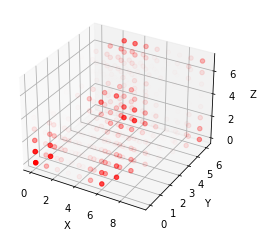

In [73]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

orig_value_arr7_normalized = (orig_value_arr7 - np.min(orig_value_arr7))
orig_value_arr7_normalized /= np.max(orig_value_arr7_normalized)

# sc = ax.scatter(coords_on_R_arr7[:,0], coords_on_R_arr7[:,1], coords_on_R_arr7[:,2], c=orig_value_arr7, cmap=cm.viridis_r, depthshade=False)
sc = scatter(ax, coords_on_R_arr7[:,0], coords_on_R_arr7[:,1], coords_on_R_arr7[:,2], color='red', alpha_arr=orig_value_arr7_normalized, depthshade=False)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# fig.colorbar(sc, ax=ax)

plt.show()

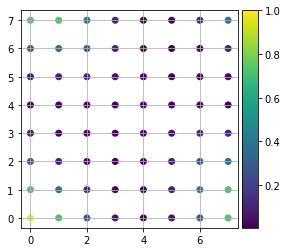

In [31]:
slice_z = 0
idx_slice_z = (coords_on_R_arr7[:,2] == slice_z)

f, ax1 = plt.subplots(1, 1, sharex=True, sharey=True)
# ax1.set_xlim(left=-0.05, right=1.05)
# ax1.set_ylim(bottom=-0.05, top=1.05)
ax1.set_aspect('equal', 'box')
sc1 = ax1.scatter(coords_on_R_arr7[idx_slice_z,0], coords_on_R_arr7[idx_slice_z,1], c=orig_value_arr7[idx_slice_z], cmap=cm.viridis)
ax1.grid()
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
f.colorbar(sc1, cax=cax1)
plt.show()

In [90]:
# Move function to dual space , then to T**3
func_dual = func_periodized.dft()
phi_periodize_ann = phi_periodize.annihilator()

# Compute a Voronoi transversal function, interpret on R**3
scaling_factor = phi_sample.det()
sigma = voronoi(phi_sample.dual(), norm_p = 2)

orig_value_arr = np.empty((n*n*n))
value_arr = np.empty((n*n*n, 2))
coords_on_R_arr = np.empty((n*n*n, 3))

for idx, element in enumerate(func_dual.domain.elements_by_maxnorm()):
    value = func_dual(element)*scaling_factor
    coords_on_R = (phi_periodize_ann(element))

    orig_value_arr[idx] = sympy.arg(value)
    value_arr[idx, :] = value.as_real_imag()
    coords_on_R_arr[idx, :] = coords_on_R

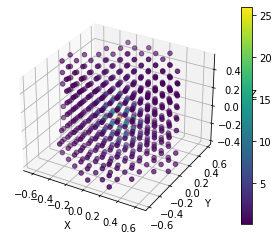

In [5]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

sc = ax.scatter(coords_on_R_arr[:,0], coords_on_R_arr[:,1], coords_on_R_arr[:,2], c=np.linalg.norm(value_arr, axis=1), cmap=cm.viridis)
# sc = ax.scatter(coords_on_R_arr[:,0], coords_on_R_arr[:,1], coords_on_R_arr[:,2], c=np.linalg.norm(value_arr, axis=1), alpha=np.linalg.norm(value_arr, axis=1)/np.max(np.linalg.norm(value_arr, axis=1)), cmap=cm.viridis)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

fig.colorbar(sc, ax=ax)

plt.show()

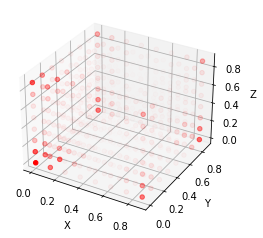

In [77]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

value_arr_normalized = (np.linalg.norm(value_arr, axis=1) - np.min(np.linalg.norm(value_arr, axis=1)))
value_arr_normalized /= np.max(value_arr_normalized)

# sc = ax.scatter(coords_on_R_arr[:,0], coords_on_R_arr[:,1], coords_on_R_arr[:,2], c=np.linalg.norm(value_arr, axis=1), cmap=cm.viridis)
# sc = ax.scatter(coords_on_R_arr[:,0], coords_on_R_arr[:,1], coords_on_R_arr[:,2], c=orig_value_arr, cmap=cm.viridis)
sc = scatter(ax, coords_on_R_arr[:,0], coords_on_R_arr[:,1], coords_on_R_arr[:,2], color='red', alpha_arr=value_arr_normalized, depthshade=False)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# fig.colorbar(sc, ax=ax)

plt.show()

In [87]:
# crop frequency space reconstruction
num_retained_components = 5*5*5

domain8 = func_dual.domain
table8_arr = np.zeros((n, n, n), dtype=np.complex128)
for idx, element in enumerate(func_dual.domain.elements_by_maxnorm()):
    index = tuple(element)
    # print(idx, index)
    # print(abs(func_dual([*index])), func_dual([*index]))
    if idx >= num_retained_components:
        break
    table8_arr[index] = func_dual([*index])

table8 = table8_arr.tolist()

tmp8 = LCAFunc(table8, domain8)

In [88]:
maxy8 = 0.0
for idx, element in enumerate(func_dual.domain.elements_by_maxnorm()):
    tmpy = abs(func_dual(element) - tmp8(element))
    if tmpy > maxy8:
        maxy8 = tmpy

print(maxy8)

2.4963583329065147


In [93]:
# Move function to dual space , then to T**3
gauss = func_dual.idft()
# gauss = tmp8.idft()
phi_periodize_ann9 = phi_periodize.annihilator()

# Compute a Voronoi transversal function, interpret on R**3
scaling_factor9 = phi_sample.det()
sigma9 = phi_sample.dual()

orig_value_arr9 = np.empty((n*n*n))
coords_on_R_arr9 = np.empty((n*n*n, 3))

for idx, element in enumerate(gauss.domain.elements_by_maxnorm()):
    value9 = gauss(element)*scaling_factor9
    coords_on_R9 = (phi_periodize_ann9(element))

    coords_on_R9[0] += coords_on_R9[1]*0.5
    if coords_on_R9[0] >= 1.0:
        pass
        # coords_on_R9[0] -= 1.0  # FIXME: fails if abs(coords_on_R9[0]) >= 2.0
    
    coords_on_R9[1] = sqrt(3)/2 * coords_on_R9[1]

    orig_value_arr9[idx] = value9
    coords_on_R_arr9[idx, :] = coords_on_R9

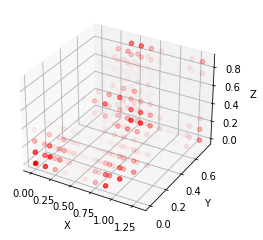

In [94]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

orig_value_arr9_normalized = (orig_value_arr9 - np.min(orig_value_arr9))
orig_value_arr9_normalized /= np.max(orig_value_arr9_normalized)

# sc = ax.scatter(coords_on_R_arr9[:,0], coords_on_R_arr9[:,1], coords_on_R_arr9[:,2], c=orig_value_arr9, cmap=cm.viridis_r, depthshade=False)
sc = scatter(ax, coords_on_R_arr9[:,0], coords_on_R_arr9[:,1], coords_on_R_arr9[:,2], color='red', alpha_arr=orig_value_arr9_normalized, depthshade=False)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# fig.colorbar(sc, ax=ax)

plt.show()

In [6]:
tmp = func_dual.idft()

maxy = 0.0
for idx, element in enumerate(func_periodized.domain.elements_by_maxnorm()):
    # print(func_periodized(element))
    # print(tmp(element))
    tmpy = abs(func_periodized(element) - tmp(element))
    if tmpy > maxy:
        maxy = tmpy

print(maxy)

1.7081605227509122e-16


In [7]:
domain2 = func_periodized.domain
table2_arr = np.zeros((n, n, n), dtype=np.complex128)
for index, x in np.ndenumerate(table2_arr):
    table2_arr[index] = tmp([*index])
# len(table2.tolist()[0][0])
table2 = table2_arr.tolist()

In [8]:
tmp2 = LCAFunc(table2, domain2)

maxy2 = 0.0
for idx, element in enumerate(func_periodized.domain.elements_by_maxnorm()):
    tmpy = abs(func_periodized(element) - tmp2(element))
    if tmpy > maxy2:
        maxy2 = tmpy

print(maxy2)

1.7081605227509122e-16


In [ ]:
# TODO: [continue here]
#  - fix 3d computation (parallelogram stacked vertically, phases should be 0 for 'standard'-bump)
#  - plot gaussian in 'regular' space: nearly done for 2D
#  - crop some coefficients

In [11]:
# Move function to dual space , then to T**2
# tmp2
phi_periodize_ann2 = phi_periodize.annihilator()

# Compute a Voronoi transversal function, interpret on R**3
scaling_factor2 = phi_sample.det()
sigma2 = voronoi(phi_sample.dual(), norm_p = 2)

orig_value_arr2 = np.empty((n*n*n))
coords_on_R_arr2 = np.empty((n*n*n, 3))

for idx, element in enumerate(tmp2.domain.elements_by_maxnorm()):
    value2 = tmp2(element)*scaling_factor2
    coords_on_R2 = phi_periodize_ann2(element)

    orig_value_arr2[idx] = value2
    coords_on_R_arr2[idx, :] = coords_on_R2

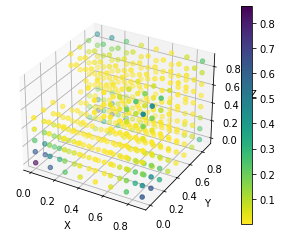

In [39]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

threshold = 0.0005
indices_to_plot = orig_value_arr2 >= threshold

sc = ax.scatter(coords_on_R_arr2[indices_to_plot,0], coords_on_R_arr2[indices_to_plot,1], coords_on_R_arr2[indices_to_plot,2], c=orig_value_arr2[indices_to_plot], cmap=cm.viridis_r)
# sc = ax.scatter(coords_on_R_arr2[indices_to_plot,0], coords_on_R_arr2[indices_to_plot,1], coords_on_R_arr2[indices_to_plot,2], c=orig_value_arr2[indices_to_plot], alpha=(1 - orig_value_arr2[indices_to_plot]/np.max(orig_value_arr2[indices_to_plot])), cmap=cm.viridis_r)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

fig.colorbar(sc, ax=ax)

plt.show()

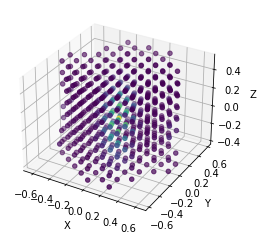

In [10]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(coords_on_R_arr2[:,0], coords_on_R_arr2[:,1], coords_on_R_arr2[:,2], c=orig_value_arr2, cmap=cm.viridis)
# ax.scatter(coords_on_R_arr[:,0], coords_on_R_arr[:,1], coords_on_R_arr[:,2], c=orig_value_arr2, alpha=orig_value_arr2/np.max(orig_value_arr2), cmap=cm.viridis)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

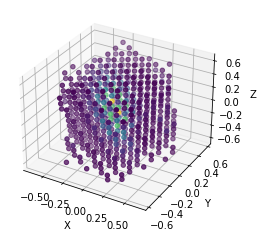

In [156]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(coords_on_R_arr2[:,0], coords_on_R_arr2[:,1], coords_on_R_arr2[:,2], c=orig_value_arr2, cmap=cm.viridis)
# ax.scatter(coords_on_R_arr[:,0], coords_on_R_arr[:,1], coords_on_R_arr[:,2], c=orig_value_arr2, alpha=orig_value_arr2/np.max(orig_value_arr2), cmap=cm.viridis)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()